#Multiplicação de matrizes em paralelo usando GPU com CUDA
##Integrantes do grupo:  
João Vitor Fidelis Cardozo, RA: 769719;  
Rômulo Alves, RA: 757944.

A princípio, foi executado o código abaixo, o qual mostra algumas informações sobre a GPU utilizada. Nesse caso, foi a Tesla T4, a qual possui tamanho máximo de 1024 threads por bloco. É necessário ressaltar, que o tamanho do warp para esse dispositivo, é de 32 threads, então já é esperado para o trabalho, obter um ótimo desempenho caso for definido um número de threads em um bloco, como múltiplo do tamanho desse warp.

In [10]:
%%writefile gpu_test.cu

#include <stdio.h>
#include <cuda_runtime.h>

int main()
{
    int deviceCount;
    cudaGetDeviceCount(&deviceCount);

    for (int dev = 0; dev < deviceCount; dev++) {
        cudaDeviceProp deviceProp;
        cudaGetDeviceProperties(&deviceProp, dev);

        printf("Device %d: %s\n", dev, deviceProp.name);
        printf("  Maximum number of threads per block: %d\n", deviceProp.maxThreadsPerBlock);
        printf("  Maximum number of blocks per grid:   %d x %d x %d\n", deviceProp.maxGridSize[0], deviceProp.maxGridSize[1], deviceProp.maxGridSize[2]);
    }

    return 0;
}


Writing gpu_test.cu


In [12]:
! nvcc gpu_test.cu -o gpu_test
! ./gpu_test


Device 0: Tesla T4
  Maximum number of threads per block: 1024
  Maximum number of blocks per grid:   2147483647 x 65535 x 65535


Logo abaixo, é possível verificar o código principal da multiplicação de matrizes em GPU com CUDA, verificando também, os resultados da versão serializada.

In [1]:
%%writefile mm.cu

#include <stdlib.h> 
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define DIM 32

float *A, *B, *C;
float *d_A, *d_B, *d_C;


__global__ void multiplicacaoMatrizes(float *A, float *B, float *C, int dim) 
{
	unsigned idx = blockIdx.x * blockDim.x + threadIdx.x;
  unsigned idy = blockIdx.y * blockDim.y + threadIdx.y;
	int k = 0;
	
	for (k = 0; k < dim; k++){
		if (idx < dim && idy < dim) 
			C[idx*dim + idy] = C[idx*dim + idy] + A[idx*dim + k] * B[k*dim + idy];
	}
}


int
main(int argc, char *argv[])
{
  int i,j,k;
  int lin, col;

  lin = col = DIM;
	size_t tam_mat = lin * col * sizeof(float);

	// Alocacao dinâmica das matrizes, com linhas em sequência 
	A = (float *) malloc (tam_mat);
	B = (float *) malloc (tam_mat);
	C = (float *) malloc (tam_mat);

 	// Atribucao de valores iniciais às matrizes 
	// Opa! Vai gerar valores aleatórios em paralelo?
 	srand(time(NULL));
	for(i=0; i < lin * col; i++) { 
		//A[i]=(float)rand() / (float)RAND_MAX; 
		//B[i]=(float)rand() / (float)RAND_MAX; 
		A[i] = 3.00;
		B[i] = 4.00;
	}

  // zerar matriz C?
	for (i=0; i < lin * col; i++){
		C[i] = 0;
	}
	
	//Alocação de espaço para as matrizes na GPU
	cudaMalloc((void **)&d_A, tam_mat);
	cudaMalloc((void **)&d_B, tam_mat);
	cudaMalloc((void **)&d_C, tam_mat);

	// Cópia dos dados de A e B para d_A e d_B. Não precisa copiar C!
	cudaMemcpy(d_A, A, tam_mat, cudaMemcpyHostToDevice);
	cudaMemcpy(d_B, B, tam_mat, cudaMemcpyHostToDevice);


  // Definição do bloco e da grade
  dim3 block;
  
	//1024 blocos;


  block.x = 32;
  block.y = 32;
  block.z = 1;

  dim3 grid;
  grid.x = (DIM + block.x -1) / block.x;
  grid.y = (DIM + block.y -1) / block.y;
  grid.z = 1;

	// calculo da multiplicação
	
	//Invocação do kernel
	multiplicacaoMatrizes <<< grid, block >>> (d_A, d_B, d_C, DIM);
	
	cudaError_t err = cudaGetLastError(); 
  if (err!= cudaSuccess) {
    printf("Erro: %s\n", cudaGetErrorString(err));
    exit(0);
  }

	// Espera execução do kernel ser concluúida para transferir dados de d_C para C
  // Também seria possível inverter, ativando cópia de memória e sincronizando depois
	// cudaDeviceSynchronize();
	cudaMemcpy(C, d_C, tam_mat, cudaMemcpyDeviceToHost);
  cudaDeviceSynchronize();
	
  // Libera memória na GPU
	cudaFree(d_A);
	cudaFree(d_B);
	cudaFree(d_C);

  // Conferindo os valores produzidos
  float maxError = 0.0f;
  for (int i = 0; i < lin * col; i++)
    maxError = max(maxError, abs(C[i]-0.3));
  printf("Max error: %f\n", maxError);

	printf("Resultados com CUDA:\n");
	for (i=0; i< lin; i++){
		for (j=0; j < col; j++){
			printf("%f ", C[i*col+j]);
		}
		printf("\n");
	}



	printf("\n\nTestando versão sequencial:\n");
	
	// Quais operações podem ser calculadas em paralelo?
  // O que pode ser calculado por todas as threads ao mesmo tempo?
   
	for(i=0; i < lin; i++) 
		for(j=0; j < col; j++) {
			// pode ser útil usar uma variável auxiliar para os cálculos
			C[i*col+j]=0;
			for(k=0; k < col; k++) 
				C[i*col+j] = C[i*col+j] + A[i*col+k] * B[k*col+j];
       // ser usou variável auxiliar, atribua seu valor à C[i][j]
		}


	printf("Resultados com na versao sequencial:\n");
	for (i=0; i< lin; i++){
		for (j=0; j < col; j++){
			printf("%f ", C[i*col+j]);
		}
		printf("\n");
	}
	

	// Libera memória - CPU / RAM
	free(A);
	free(B);
	free(C);
 
	return(0);
}


Writing mm.cu


In [2]:
! nvcc mm.cu -o mm -O3
! ./mm
#!nvprof --print-gpu-trace ./mm
#! time ./mm 

Max error: 383.700012
Resultados com CUDA:
384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 
384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 
384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.000000 384.00000

Na célula acima, é possível visualizar os resultados gerados pela versão implementada com CUDA e pela versão implementada de forma serial. É necessário ressaltar, que foi testado com uma matriz quadrada de dimensão 32, para ser possível realizar essa comparação de resultados de forma mais explícita e simplificada. 

Os valores atribuídos para todas as linhas da matriz A, foram 3.0 e para a matriz B, foram todos iguais a 4.0. Como resultado dessa operação (AxB), é esperado que uma matriz C seja gerada, com todas as linhas e colunas contendo o valor de 384.0. 

Além disso, é preciso dizer não foi utilizada uma função de gerar valores aleatórios com ponto flutuante, devido ao erro atribuído a esse tipo de operação o que, possivelmente, tornaria essa verificação de resultados incerta.

Após a implementação e a verificação dos resultados obtidos, foram feitas diferentes formas de particionamento de blocos de threads, com uma matriz quadrada de dimensão 1024. É importante lembrar que o tamanho máximo do bloco, pode ser de 1024 threads. Sendo assim, essas estratégias foram:

*   Tamanho de bloco de threads 8x8;
*   Tamanho de bloco de threads 16x16;
*   Tamanho de bloco de threads 32x32;
*   Tamanho de bloco de threads 8x16;



## Caso 1) Testando com blocos de threads de tamanho 8x8.


In [19]:
%%writefile mm_test1.cu

#include <stdlib.h> 
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define DIM 1024

float *A, *B, *C;
float *d_A, *d_B, *d_C;


__global__ void multiplicacaoMatrizes(float *A, float *B, float *C, int dim) 
{
	unsigned idx = blockIdx.x * blockDim.x + threadIdx.x;
  unsigned idy = blockIdx.y * blockDim.y + threadIdx.y;
	int k = 0;
	
	for (k = 0; k < dim; k++){
		if (idx < dim && idy < dim) 
			C[idx*dim + idy] = C[idx*dim + idy] + A[idx*dim + k] * B[k*dim + idy];
	}
}


int
main(int argc, char *argv[])
{
  int i;
  int lin, col;

  lin = col = DIM;
	size_t tam_mat = lin * col * sizeof(float);

	// Alocacao dinâmica das matrizes, com linhas em sequência 
	A = (float *) malloc (tam_mat);
	B = (float *) malloc (tam_mat);
	C = (float *) malloc (tam_mat);

 	// Atribucao de valores iniciais às matrizes 
	// Opa! Vai gerar valores aleatórios em paralelo?
 	srand(time(NULL));
	for(i=0; i < lin * col; i++) { 
		//A[i]=(float)rand() / (float)RAND_MAX; 
		//B[i]=(float)rand() / (float)RAND_MAX; 
		A[i] = 3.00;
		B[i] = 4.00;
	}

  // zerar matriz C?
	for (i=0; i < lin * col; i++){
		C[i] = 0;
	}
	
	//Alocação de espaço para as matrizes na GPU
	cudaMalloc((void **)&d_A, tam_mat);
	cudaMalloc((void **)&d_B, tam_mat);
	cudaMalloc((void **)&d_C, tam_mat);

	// Cópia dos dados de A e B para d_A e d_B. Não precisa copiar C!
	cudaMemcpy(d_A, A, tam_mat, cudaMemcpyHostToDevice);
	cudaMemcpy(d_B, B, tam_mat, cudaMemcpyHostToDevice);


  // Definição do bloco e da grade
  dim3 block;
  
	//64 blocos - 8x8
  block.x = 8;
  block.y = 8;
  block.z = 1;

  dim3 grid;
  grid.x = (DIM + block.x -1) / block.x;
  grid.y = (DIM + block.y -1) / block.y;
  grid.z = 1;

	// calculo da multiplicação
	
	//Invocação do kernel
	multiplicacaoMatrizes <<< grid, block >>> (d_A, d_B, d_C, DIM);
	
	cudaError_t err = cudaGetLastError(); 
  if (err!= cudaSuccess) {
    printf("Erro: %s\n", cudaGetErrorString(err));
    exit(0);
  }

	// Espera execução do kernel ser concluúida para transferir dados de d_C para C
  // Também seria possível inverter, ativando cópia de memória e sincronizando depois
	// cudaDeviceSynchronize();
	cudaMemcpy(C, d_C, tam_mat, cudaMemcpyDeviceToHost);
  cudaDeviceSynchronize();
	
  // Libera memória na GPU
	cudaFree(d_A);
	cudaFree(d_B);
	cudaFree(d_C);

  
  // Conferindo os valores produzidos
  float maxError = 0.0f;
  for (int i = 0; i < lin * col; i++)
    maxError = max(maxError, abs(C[i]-0.3));
  printf("Max error: %f\n", maxError);
   

	// Libera memória - CPU / RAM
	free(A);
	free(B);
	free(C);
 
	return(0);
}


Overwriting mm_test1.cu


## Caso 2) Testando com blocos de threads de tamanho 16x16.


In [20]:
%%writefile mm_test2.cu

#include <stdlib.h> 
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define DIM 1024

float *A, *B, *C;
float *d_A, *d_B, *d_C;


__global__ void multiplicacaoMatrizes(float *A, float *B, float *C, int dim) 
{
	unsigned idx = blockIdx.x * blockDim.x + threadIdx.x;
  unsigned idy = blockIdx.y * blockDim.y + threadIdx.y;
	int k = 0;
	
	for (k = 0; k < dim; k++){
		if (idx < dim && idy < dim) 
			C[idx*dim + idy] = C[idx*dim + idy] + A[idx*dim + k] * B[k*dim + idy];
	}
}


int
main(int argc, char *argv[])
{
  int i;
  int lin, col;

  lin = col = DIM;
	size_t tam_mat = lin * col * sizeof(float);

	// Alocacao dinâmica das matrizes, com linhas em sequência 
	A = (float *) malloc (tam_mat);
	B = (float *) malloc (tam_mat);
	C = (float *) malloc (tam_mat);

 	// Atribucao de valores iniciais às matrizes 
	// Opa! Vai gerar valores aleatórios em paralelo?
 	srand(time(NULL));
	for(i=0; i < lin * col; i++) { 
		//A[i]=(float)rand() / (float)RAND_MAX; 
		//B[i]=(float)rand() / (float)RAND_MAX; 
		A[i] = 3.00;
		B[i] = 4.00;
	}

  // zerar matriz C?
	for (i=0; i < lin * col; i++){
		C[i] = 0;
	}
	
	//Alocação de espaço para as matrizes na GPU
	cudaMalloc((void **)&d_A, tam_mat);
	cudaMalloc((void **)&d_B, tam_mat);
	cudaMalloc((void **)&d_C, tam_mat);

	// Cópia dos dados de A e B para d_A e d_B. Não precisa copiar C!
	cudaMemcpy(d_A, A, tam_mat, cudaMemcpyHostToDevice);
	cudaMemcpy(d_B, B, tam_mat, cudaMemcpyHostToDevice);


  // Definição do bloco e da grade
  dim3 block;
  
	//256 blocos - 16x16
  block.x = 16;
  block.y = 16;
  block.z = 1;

  dim3 grid;
  grid.x = (DIM + block.x -1) / block.x;
  grid.y = (DIM + block.y -1) / block.y;
  grid.z = 1;

	// calculo da multiplicação
	
	//Invocação do kernel
	multiplicacaoMatrizes <<< grid, block >>> (d_A, d_B, d_C, DIM);
	
	cudaError_t err = cudaGetLastError(); 
  if (err!= cudaSuccess) {
    printf("Erro: %s\n", cudaGetErrorString(err));
    exit(0);
  }

	// Espera execução do kernel ser concluúida para transferir dados de d_C para C
  // Também seria possível inverter, ativando cópia de memória e sincronizando depois
	// cudaDeviceSynchronize();
	cudaMemcpy(C, d_C, tam_mat, cudaMemcpyDeviceToHost);
  cudaDeviceSynchronize();
	
  // Libera memória na GPU
	cudaFree(d_A);
	cudaFree(d_B);
	cudaFree(d_C);

  
  // Conferindo os valores produzidos
  float maxError = 0.0f;
  for (int i = 0; i < lin * col; i++)
    maxError = max(maxError, abs(C[i]-0.3));
  printf("Max error: %f\n", maxError);
   

	// Libera memória - CPU / RAM
	free(A);
	free(B);
	free(C);
 
	return(0);
}


Overwriting mm_test2.cu


## Caso 3) Testando com blocos de threads de tamanho 32x32.


In [15]:
%%writefile mm_test3.cu

#include <stdlib.h> 
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define DIM 1024

float *A, *B, *C;
float *d_A, *d_B, *d_C;


__global__ void multiplicacaoMatrizes(float *A, float *B, float *C, int dim) 
{
	unsigned idx = blockIdx.x * blockDim.x + threadIdx.x;
  unsigned idy = blockIdx.y * blockDim.y + threadIdx.y;
	int k = 0;
	
	for (k = 0; k < dim; k++){
		if (idx < dim && idy < dim) 
			C[idx*dim + idy] = C[idx*dim + idy] + A[idx*dim + k] * B[k*dim + idy];
	}
}


int
main(int argc, char *argv[])
{
  int i;
  int lin, col;

  lin = col = DIM;
	size_t tam_mat = lin * col * sizeof(float);

	// Alocacao dinâmica das matrizes, com linhas em sequência 
	A = (float *) malloc (tam_mat);
	B = (float *) malloc (tam_mat);
	C = (float *) malloc (tam_mat);

 	// Atribucao de valores iniciais às matrizes 
	// Opa! Vai gerar valores aleatórios em paralelo?
 	srand(time(NULL));
	for(i=0; i < lin * col; i++) { 
		//A[i]=(float)rand() / (float)RAND_MAX; 
		//B[i]=(float)rand() / (float)RAND_MAX; 
		A[i] = 3.00;
		B[i] = 4.00;
	}

  // zerar matriz C?
	for (i=0; i < lin * col; i++){
		C[i] = 0;
	}
	
	//Alocação de espaço para as matrizes na GPU
	cudaMalloc((void **)&d_A, tam_mat);
	cudaMalloc((void **)&d_B, tam_mat);
	cudaMalloc((void **)&d_C, tam_mat);

	// Cópia dos dados de A e B para d_A e d_B. Não precisa copiar C!
	cudaMemcpy(d_A, A, tam_mat, cudaMemcpyHostToDevice);
	cudaMemcpy(d_B, B, tam_mat, cudaMemcpyHostToDevice);


  // Definição do bloco e da grade
  dim3 block;
  
	//1024 blocos - 32x32
  block.x = 32;
  block.y = 32;
  block.z = 1;

  dim3 grid;
  grid.x = (DIM + block.x -1) / block.x;
  grid.y = (DIM + block.y -1) / block.y;
  grid.z = 1;

	// calculo da multiplicação
	
	//Invocação do kernel
	multiplicacaoMatrizes <<< grid, block >>> (d_A, d_B, d_C, DIM);
	
	cudaError_t err = cudaGetLastError(); 
  if (err!= cudaSuccess) {
    printf("Erro: %s\n", cudaGetErrorString(err));
    exit(0);
  }

	// Espera execução do kernel ser concluúida para transferir dados de d_C para C
  // Também seria possível inverter, ativando cópia de memória e sincronizando depois
	// cudaDeviceSynchronize();
	cudaMemcpy(C, d_C, tam_mat, cudaMemcpyDeviceToHost);
  cudaDeviceSynchronize();
	
  // Libera memória na GPU
	cudaFree(d_A);
	cudaFree(d_B);
	cudaFree(d_C);

  
  // Conferindo os valores produzidos
  float maxError = 0.0f;
  for (int i = 0; i < lin * col; i++)
    maxError = max(maxError, abs(C[i]-0.3));
  printf("Max error: %f\n", maxError);
   

	// Libera memória - CPU / RAM
	free(A);
	free(B);
	free(C);
 
	return(0);
}


Writing mm_test3.cu


## Caso 4) Testando com blocos de threads de tamanho 8x16.


In [18]:
%%writefile mm_test4.cu

#include <stdlib.h> 
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define DIM 1024

float *A, *B, *C;
float *d_A, *d_B, *d_C;


__global__ void multiplicacaoMatrizes(float *A, float *B, float *C, int dim) 
{
	unsigned idx = blockIdx.x * blockDim.x + threadIdx.x;
  unsigned idy = blockIdx.y * blockDim.y + threadIdx.y;
	int k = 0;
	
	for (k = 0; k < dim; k++){
		if (idx < dim && idy < dim) 
			C[idx*dim + idy] = C[idx*dim + idy] + A[idx*dim + k] * B[k*dim + idy];
	}
}


int
main(int argc, char *argv[])
{
  int i;
  int lin, col;

  lin = col = DIM;
	size_t tam_mat = lin * col * sizeof(float);

	// Alocacao dinâmica das matrizes, com linhas em sequência 
	A = (float *) malloc (tam_mat);
	B = (float *) malloc (tam_mat);
	C = (float *) malloc (tam_mat);

 	// Atribucao de valores iniciais às matrizes 
	// Opa! Vai gerar valores aleatórios em paralelo?
 	srand(time(NULL));
	for(i=0; i < lin * col; i++) { 
		//A[i]=(float)rand() / (float)RAND_MAX; 
		//B[i]=(float)rand() / (float)RAND_MAX; 
		A[i] = 3.00;
		B[i] = 4.00;
	}

  // zerar matriz C?
	for (i=0; i < lin * col; i++){
		C[i] = 0;
	}
	
	//Alocação de espaço para as matrizes na GPU
	cudaMalloc((void **)&d_A, tam_mat);
	cudaMalloc((void **)&d_B, tam_mat);
	cudaMalloc((void **)&d_C, tam_mat);

	// Cópia dos dados de A e B para d_A e d_B. Não precisa copiar C!
	cudaMemcpy(d_A, A, tam_mat, cudaMemcpyHostToDevice);
	cudaMemcpy(d_B, B, tam_mat, cudaMemcpyHostToDevice);


  // Definição do bloco e da grade
  dim3 block;
  
	//128 blocos - 8x16
  block.x = 8;
  block.y = 16;
  block.z = 1;

  dim3 grid;
  grid.x = (DIM + block.x -1) / block.x;
  grid.y = (DIM + block.y -1) / block.y;
  grid.z = 1;

	// calculo da multiplicação
	
	//Invocação do kernel
	multiplicacaoMatrizes <<< grid, block >>> (d_A, d_B, d_C, DIM);
	
	cudaError_t err = cudaGetLastError(); 
  if (err!= cudaSuccess) {
    printf("Erro: %s\n", cudaGetErrorString(err));
    exit(0);
  }

	// Espera execução do kernel ser concluúida para transferir dados de d_C para C
  // Também seria possível inverter, ativando cópia de memória e sincronizando depois
	// cudaDeviceSynchronize();
	cudaMemcpy(C, d_C, tam_mat, cudaMemcpyDeviceToHost);
  cudaDeviceSynchronize();
	
  // Libera memória na GPU
	cudaFree(d_A);
	cudaFree(d_B);
	cudaFree(d_C);

  
  // Conferindo os valores produzidos
  float maxError = 0.0f;
  for (int i = 0; i < lin * col; i++)
    maxError = max(maxError, abs(C[i]-0.3));
  printf("Max error: %f\n", maxError);
   

	// Libera memória - CPU / RAM
	free(A);
	free(B);
	free(C);
 
	return(0);
}


Writing mm_test4.cu


##Comparação de resultados

In [22]:
! nvcc mm_test1.cu -o mm_test1
! nvcc mm_test2.cu -o mm_test2
! nvcc mm_test3.cu -o mm_test3
! nvcc mm_test4.cu -o mm_test4


In [25]:
! echo Usando 8x8
! nvprof --print-gpu-trace ./mm_test1 | grep multiplicacaoMatrizes
! echo
! echo Usando 16x16
! nvprof --print-gpu-trace ./mm_test2 | grep multiplicacaoMatrizes
! echo
! echo Usando 32x32
! nvprof --print-gpu-trace ./mm_test3 | grep multiplicacaoMatrizes
! echo
! echo Usando 8x16
! nvprof --print-gpu-trace ./mm_test4 | grep multiplicacaoMatrizes
! echo

Usando 8x8
==20024== NVPROF is profiling process 20024, command: ./mm_test1
==20024== Profiling application: ./mm_test1
==20024== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
339.22ms  766.62us                    -               -         -         -         -  4.0000MB  5.0954GB/s    Pageable      Device     Tesla T4 (0)         1         7  [CUDA memcpy HtoD]
340.22ms  751.26us                    -               -         -         -         -  4.0000MB  5.1996GB/s    Pageable      Device     Tesla T4 (0)         1         7  [CUDA memcpy HtoD]
340.98ms  73.434ms          (128 128 1)         (8 8 1)        28        0B        0B         -           -           -           -     Tesla T4 (0)         1         7  multiplicacaoMatrizes(float*, float*, float*, int) [116]
414.42ms  691.16us                    -               -         -       

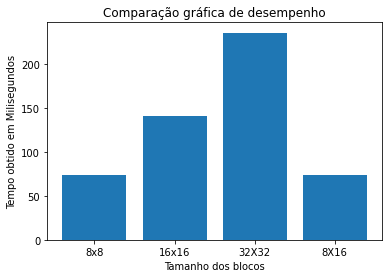

In [26]:
import matplotlib.pyplot as plt
import numpy as np

tamanhoBlocos = ['8x8', '16x16', '32X32', '8X16']
tempoObtido = [73.434, 140.46, 235.38, 73.506]

plt.bar(tamanhoBlocos, tempoObtido)
plt.ylabel('Tempo obtido em Milisegundos')
plt.xlabel('Tamanho dos blocos')
plt.title('Comparação gráfica de desempenho')


plt.show()

O melhor desempenho para a multiplicação de matrizes foi obtido quando declarado um bloco de tamanho 8x8. É necessário ressaltar, que 8x8 < 1024threads (tamanho limite) e, permite que um bloco inteiro execute em uma SM.